Here we will use the samples of students articulating vowels and mimicking instrument and animal sounds. We hypothesized that though NSynth was trained on both instruments and voices, it would not be able to generalize particularly well on voices imitating instruments, and would be even worse with voices imitating animals, as animal sounds were not part of either NSynths voice or instrument datasets. Now let's found out how our assumptions fared..


# E-Z NSynth (NOTE: USE PYTHON 2 W/ GPU)




# Setup Environment

We need to start downloading and choosing a pretrained NSynth model to use. 

In [1]:
#@title Setup Environment
#@test {"output": "ignore"}


# Install magenta
print('Installing Magenta...\n')
!pip install -q magenta
print('Installing ffmpeg...\n')
!echo "Yes" | apt-get install ffmpeg > /dev/null


print('Downloading Pretrained Models...\n')
# Copy checkpoints from google cloud
# Copying 1GB, takes a minute
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null


print('Importing Modules...\n')
# Load modules and helper functions
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

from google.colab import files
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from magenta.music.notebook_utils import colab_play as play
import librosa

print('Sucess!! Magenta environment is now setup.')


Installing Magenta...

Installing ffmpeg...


Getting Instruments Model...

Getting Voices Model...

Importing Modules...

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Sucess!! Magenta environment is now setup.


In [2]:
#@title Choose a Model { vertical-output: true, run: "auto" }
Model = "Both" #@param ["Instruments", "Voices", "Both"] {type:"string"}
ckpts = {'Instruments': '/content/wavenet-ckpt/model.ckpt-200000',
         'Voices': '/content/wavenet-voice-ckpt/model.ckpt-200000'}

if Model == "Both":
  ckpt_path = [ckpts[key] for key in ckpts]
  print(ckpt_path)
  #for key in ckpts:
    #print(ckpts[key])
    #ckpts_path[key.split(',') for key in key]
else:
  ckpt_path = ckpts[Model]
  print(ckpt_path)
print('Using model pretrained on %s.' % Model)

['/content/wavenet-ckpt/model.ckpt-200000', '/content/wavenet-voice-ckpt/model.ckpt-200000']
Using model pretrained on Both.


In [3]:
print(ckpt_path)

['/content/wavenet-ckpt/model.ckpt-200000', '/content/wavenet-voice-ckpt/model.ckpt-200000']


Helper functions, variables and parameters for uploading wav files or npy embeddings

In [0]:
def upload_wav(sample_length, sr):
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list, audio_list = [], []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/', key)
    with open(fname, 'w') as f:
      f.write(value)
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    file_list.append(fname)
    audio_list.append(audio)
  return file_list, audio_list

def upload_npy():
  '''Upload an .npy file. No need for content'''
  filemap = files.upload()
  name_list, file_list, enc_list = [], [], []
  for fname, value in filemap.items():
    with open(fname, 'wb') as f:
      f.write(value)
    name_list.append(str(os.path.splitext(fname)[0]))
    file_list.append(str(fname))
    enc_list.append(np.load(str(fname)))   
  return name_list, file_list, enc_list


download = files.download
get_name = lambda f: os.path.splitext(os.path.basename(f))[0]

#Set Sound Length (in Seconds) { vertical-output: true, run: "auto" }
Length = 3.0
SR = 16000
SAMPLE_LENGTH = int(SR * Length)

Put all your sound files into a single folder and maker sure to select all the files you want to reconstruct / interpolate between. **(Ctrl/Cmd/Shift Click)**

In [8]:
#@title Upload sound files (.wav, .mp3), encode and save/download embeddings
def up_enc_save(encode=True, interp='comp'):
 
  file_list, audio_list = upload_wav(sample_length=SAMPLE_LENGTH, sr=SR)
  names = [str(get_name(name)) for name in file_list]
  print(names)
  # Pad and peak normalize
  for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) > SAMPLE_LENGTH:
      audio_list[i], _ = librosa.effects.trim(audio_list[i])
      print("trim ",i,librosa.get_duration(audio_list[i]))

    if len(audio_list[i]) <= SAMPLE_LENGTH:
      audio_list[i], _ = librosa.effects.trim(audio_list[i])
      print("trim ",i,librosa.get_duration(audio_list[i]))
      padding = SAMPLE_LENGTH - len(audio_list[i])
      audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')
      print("pad ",i,librosa.get_duration(audio_list[i]))

  audio_list = np.array(audio_list)

  if encode is True:
    print('encode')
    audio = np.array(audio_list)
    z = []
    for i in range(len(ckpt_path)):
      print(i)
      if i == 0:
        z = fastgen.encode(audio, ckpt_path[i], SAMPLE_LENGTH)
        name_list = ['recon_i_' + name_ for name_ in names]
      if i > 0:
        z = np.append(z, fastgen.encode(audio, ckpt_path[i], SAMPLE_LENGTH), axis=0)
        for name_ in names:
          name_list.append('recon_v_' + name_)
    print('Encoded %d files' % z.shape[0])

    # Start with reconstructions
    encodings = [z_ for z_ in z]
    if interp == 'comp':
      # Add all the mean interpolations
      n = len(name_list)
      n_split = n/2
      for i in range(n_split-1):
        #for j in range(i + 1, n):
        new_z = (z[i] + z[i+n_split]) / 2.0
        new_name = 'interp_' + name_list[i] + '_X_'+ name_list[i+n_split]
        encodings.append(new_z)
        name_list.append(new_name)
    
    if interp == 'all':
      # Add all the mean interpolations
      n = len(name_list)
      for i in range(n - 1):
        for j in range(i + 1, n):
          new_z = (z[i] + z[j]) / 2.0
          new_name = 'interp_' + name_list[i] + '_X_'+ name_list[j]
          encodings.append(new_z)
          name_list.append(new_name)

      print("%d total: %d reconstructions and %d interpolations" % (len(name_list), n, len(name_list) - n))

  #if encode is True and save is True:
  file_list = []
  save_path = 'embeddings'
  for num, (wavfile, enc) in enumerate(zip(name_list, encodings)):
    filename = "%s_embeddings.npy" % wavfile
    file_list.append(filename)
    np.save(filename, enc)
    print('downloaded %s' % (filename))
    download(filename)
      
  return file_list, name_list, encodings, audio_list

file_list, name_list, encodings, audio_list = up_enc_save()

KeyboardInterrupt: ignored

In [0]:
print(file_list)

['recon_i_TASCAM_0103S12_embeddings.npy', 'recon_i_TASCAM_0104S12_embeddings.npy', 'recon_v_TASCAM_0103S12_embeddings.npy', 'recon_v_TASCAM_0104S12_embeddings.npy', 'interp_TASCAM_0103S12_X_TASCAM_0104S12_embeddings.npy']


We can take a look at the encoding of our npy embeddings. They are compressed representations of the audio but have some structure in their own right, (16 numbers, kind of like 16 channels of audio, so there are 16 different lines, colors are arbitrary). 

In [0]:
#@title Visualize Audio and Encoding { vertical-output: true, run: "auto" }
SoundFile = 0 #@param {type:"slider", min:0, max:10, step:1}
file_number = SoundFile

try:
  print(file_list[file_number])

  plt.figure()
  plt.plot(encodings[file_number])
  plt.title('NSynth Encoding')
except Exception as e:
  print e

name 'file_list' is not defined


# Synthesize from Temp Files (if you JUST encoded a batch of files this Colab session - else see Synthesize from Local Storage to load your npy embeddings)

On the GPU, this should take about 4 minutes per 1 second of audio per a batch.

In [0]:
#@title Synthesize Interpolations
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

encodings = np.array(encodings)
save_paths = ['/content/' + name + '.wav' for name in name_list]
fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

Total Iterations to Complete: 48000

INFO:tensorflow:Restoring parameters from /content/wavenet-voice-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content//content/recon_TASCAM_0011S12b_embeddings.npy.wav


IOError: ignored

In [0]:
#@title Synthesize Interpolations from Local Storage
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

name_list, file_list, encodings = upload_npy()
encodings = np.array(encodings)
for i in range(len(ckpt_path)):
  if i == 0:
    save_paths = ['/content/' + name + '_i.wav' for name in name_list]
    fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path[i],
                   samples_per_save=int(SAMPLE_LENGTH / 10))
  if i > 0:
    for name in name_list:
      save_paths.append('/content/' + name + '_v.wav')
      fastgen.synthesize(encodings,
                         save_paths=save_paths,
                         checkpoint_path=ckpt_path[i],
                         samples_per_save=int(SAMPLE_LENGTH / 10))

Total Iterations to Complete: 48000



Saving recon_v_TASCAM_0099S12_embeddings.npy to recon_v_TASCAM_0099S12_embeddings.npy
Saving recon_v_TASCAM_0098S12_embeddings.npy to recon_v_TASCAM_0098S12_embeddings.npy
Saving recon_v_TASCAM_0097S12_embeddings.npy to recon_v_TASCAM_0097S12_embeddings.npy
Saving recon_i_TASCAM_0099S12_embeddings.npy to recon_i_TASCAM_0099S12_embeddings.npy
Saving recon_i_TASCAM_0098S12_embeddings.npy to recon_i_TASCAM_0098S12_embeddings.npy
Saving recon_i_TASCAM_0097S12_embeddings.npy to recon_i_TASCAM_0097S12_embeddings.npy
INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/recon_i_TASCAM_0098S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_v_TASCAM_0098S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_v_TASCAM_0097S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_i_TASCAM_0097S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_i_TASCAM_0099S12_embeddings_i.wav
INFO:tensor

INFO:tensorflow:Saving: /content/recon_v_TASCAM_0097S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_i_TASCAM_0097S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_i_TASCAM_0099S12_embeddings_i.wav
INFO:tensorflow:Saving: /content/recon_v_TASCAM_0099S12_embeddings_i.wav
INFO:tensorflow:Sample: 4900
INFO:tensorflow:Sample: 5000
INFO:tensorflow:Sample: 5100
INFO:tensorflow:Sample: 5200
INFO:tensorflow:Sample: 5300
INFO:tensorflow:Sample: 5400
INFO:tensorflow:Sample: 5500
INFO:tensorflow:Sample: 5600
INFO:tensorflow:Sample: 5700
INFO:tensorflow:Sample: 5800
INFO:tensorflow:Sample: 5900
INFO:tensorflow:Sample: 6000
INFO:tensorflow:Sample: 6100
INFO:tensorflow:Sample: 6200
INFO:tensorflow:Sample: 6300
INFO:tensorflow:Sample: 6400
INFO:tensorflow:Sample: 6500
INFO:tensorflow:Sample: 6600
INFO:tensorflow:Sample: 6700
INFO:tensorflow:Sample: 6800
INFO:tensorflow:Sample: 6900
INFO:tensorflow:Sample: 7000
INFO:tensorflow:Sample: 7100
INFO:tensorflow:Sample: 7200
INFO:tensorf

INFO:tensorflow:Sample: 11300
INFO:tensorflow:Sample: 11400
INFO:tensorflow:Sample: 11500
INFO:tensorflow:Sample: 11600
INFO:tensorflow:Sample: 11700
INFO:tensorflow:Sample: 11800
INFO:tensorflow:Sample: 11900
INFO:tensorflow:Sample: 12000
INFO:tensorflow:Sample: 12100
INFO:tensorflow:Sample: 12200
INFO:tensorflow:Sample: 12300
INFO:tensorflow:Sample: 12400
INFO:tensorflow:Sample: 12500
INFO:tensorflow:Sample: 12600
INFO:tensorflow:Sample: 12700
INFO:tensorflow:Sample: 12800
INFO:tensorflow:Sample: 12900
INFO:tensorflow:Sample: 13000
INFO:tensorflow:Sample: 13100
INFO:tensorflow:Sample: 13200
INFO:tensorflow:Sample: 13300
INFO:tensorflow:Sample: 13400
INFO:tensorflow:Sample: 13500
INFO:tensorflow:Sample: 13600
INFO:tensorflow:Sample: 13700
INFO:tensorflow:Sample: 13800
INFO:tensorflow:Sample: 13900
INFO:tensorflow:Sample: 14000
INFO:tensorflow:Sample: 14100
INFO:tensorflow:Sample: 14200
INFO:tensorflow:Sample: 14300
INFO:tensorflow:Sample: 14400
INFO:tensorflow:Saving: /content/recon_i

In [0]:
# check what temp files exist
#os.listdir('.')
save_paths

NameError: ignored

In [0]:
#@title Download Interpolations
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

NameError: ignored

In [0]:
#@title Listen to the outputs

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Reconstructions:

interp_recon_v_TASCAM_0098S12_X_recon_v_TASCAM_0099S12_embeddings_i


interp_recon_v_TASCAM_0097S12_X_recon_v_TASCAM_0099S12_embeddings_i


interp_recon_v_TASCAM_0097S12_X_recon_v_TASCAM_0098S12_embeddings_i


Interpolations:

interp_recon_v_TASCAM_0098S12_X_recon_v_TASCAM_0099S12_embeddings_i


interp_recon_v_TASCAM_0097S12_X_recon_v_TASCAM_0099S12_embeddings_i


interp_recon_v_TASCAM_0097S12_X_recon_v_TASCAM_0098S12_embeddings_i


In [0]:


# use image interpolation to stretch the encoding: (pip install scikit-image)
try:
    from skimage.transform import resize
except ImportError:
    !pip install scikit-image
    from skimage.transform import resize

Here's a utility function to help you stretch your own encoding. It uses skimage.transform and will retain the range of values. Images typically only have a range of 0-1, but the encodings aren't actually images so we'll keep track of their min/max in order to stretch them like images.

In [0]:
def timestretch(encodings, factor):
    min_encoding, max_encoding = encodings.min(), encodings.max()
    encodings_norm = (encodings - min_encoding) / (max_encoding - min_encoding)
    timestretches = []
    for encoding_i in encodings_norm:
        stretched = resize(encoding_i, (int(encoding_i.shape[0] * factor), encoding_i.shape[1]), mode='reflect')
        stretched = (stretched * (max_encoding - min_encoding)) + min_encoding
        timestretches.append(stretched)
    return np.array(timestretches)

In [0]:
z_encoding_slower = timestretch(encodings, 1.5)
z_encoding_faster = timestretch(encodings, 0.5)

Text(0.5,1,u'Encoding (Slower)')

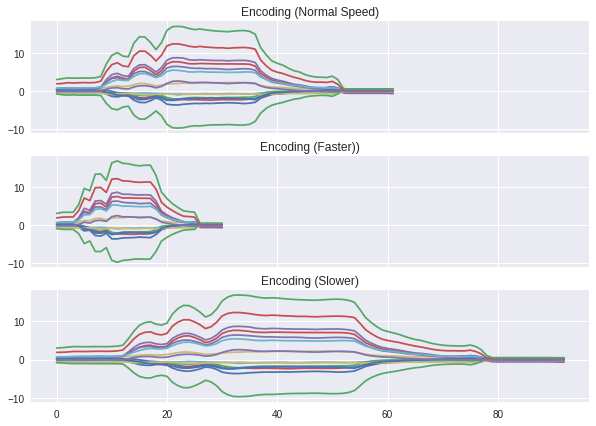

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(z[0]); 
axs[0].set_title('Encoding (Normal Speed)')
axs[1].plot(z_encoding_faster[0]);
axs[1].set_title('Encoding (Faster))')
axs[2].plot(z_encoding_slower[0]);
axs[2].set_title('Encoding (Slower)')

In [0]:
# TO-DO - build all in function w/flags for which processing to apply to batches
# Start with reconstructions
z_list = [z_ for z_ in encodings]
name_list = ['fast_stretch_' + name_ for name_ in name_list]

# Add all the mean interpolations
n = len(name_list)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (encodings[i] + encodings[j]) / 2.0
    new_name = 'interp_' + name_list[i] + '_X_'+ name_list[j]
    z_list.append(new_z)
    name_list.append(new_name)

save_paths = ['/content/' + name + '.wav' for name in name_list]    

fastgen.synthesize(z_encoding_faster, save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

INFO:tensorflow:Restoring parameters from /content/wavenet-voice-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12b_embeddings.npy.wav
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_interp_TASCAM_0011S12a_X_TASCAM_0011S12b_embeddings.npy.wav
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12a_embeddings.npy.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:

INFO:tensorflow:Sample: 6200
INFO:tensorflow:Sample: 6300
INFO:tensorflow:Sample: 6400
INFO:tensorflow:Sample: 6500
INFO:tensorflow:Sample: 6600
INFO:tensorflow:Sample: 6700
INFO:tensorflow:Sample: 6800
INFO:tensorflow:Sample: 6900
INFO:tensorflow:Sample: 7000
INFO:tensorflow:Sample: 7100
INFO:tensorflow:Sample: 7200
INFO:tensorflow:Sample: 7300
INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflo

INFO:tensorflow:Sample: 13500
INFO:tensorflow:Sample: 13600
INFO:tensorflow:Sample: 13700
INFO:tensorflow:Sample: 13800
INFO:tensorflow:Sample: 13900
INFO:tensorflow:Sample: 14000
INFO:tensorflow:Sample: 14100
INFO:tensorflow:Sample: 14200
INFO:tensorflow:Sample: 14300
INFO:tensorflow:Sample: 14400
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12b_embeddings.npy.wav
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_interp_TASCAM_0011S12a_X_TASCAM_0011S12b_embeddings.npy.wav
INFO:tensorflow:Saving: /content/fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12a_embeddings.npy.wav
INFO:tensorflow:Sample: 14500
INFO:tensorflow:Sample: 14600
INFO:tensorflow:Sample: 14700
INFO:tensorflow:Sample: 14800
INFO:tensorflow:Sample: 14900
INFO:tensorflow:Sample: 15000
INFO:tensorflow:Sample: 15100
INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INF

INFO:tensorflow:Sample: 20000
INFO:tensorflow:Sample: 20100
INFO:tensorflow:Sample: 20200
INFO:tensorflow:Sample: 20300
INFO:tensorflow:Sample: 20400
INFO:tensorflow:Sample: 20500
INFO:tensorflow:Sample: 20600
INFO:tensorflow:Sample: 20700
INFO:tensorflow:Sample: 20800
INFO:tensorflow:Sample: 20900
INFO:tensorflow:Sample: 21000
INFO:tensorflow:Sample: 21100
INFO:tensorflow:Sample: 21200
INFO:tensorflow:Sample: 21300
INFO:tensorflow:Sample: 21400
INFO:tensorflow:Sample: 21500
INFO:tensorflow:Sample: 21600
INFO:tensorflow:Sample: 21700
INFO:tensorflow:Sample: 21800
INFO:tensorflow:Sample: 21900
INFO:tensorflow:Sample: 22000
INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Sample: 22500
INFO:tensorflow:Sample: 22600
INFO:tensorflow:Sample: 22700
INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tenso

In [0]:
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12b_embeddings.npy.wav
Downloading: fast_stretch_fast_stretch_fast_stretch_fast_stretch_interp_TASCAM_0011S12a_X_TASCAM_0011S12b_embeddings.npy.wav
Downloading: fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12a_embeddings.npy.wav
Downloading: interp_fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12b_embeddings.npy_X_fast_stretch_fast_stretch_fast_stretch_fast_stretch_interp_TASCAM_0011S12a_X_TASCAM_0011S12b_embeddings.npy.wav


OSError: ignored

In [0]:
for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Reconstructions:

fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12b_embeddings.npy


fast_stretch_fast_stretch_fast_stretch_fast_stretch_interp_TASCAM_0011S12a_X_TASCAM_0011S12b_embeddings.npy


fast_stretch_fast_stretch_fast_stretch_fast_stretch_recon_TASCAM_0011S12a_embeddings.npy


Interpolations:



IOError: ignored

Part 3: Interpolating Sounds
Now let's try something more experimental. NSynth released plenty of great examples of what happens when you mix the embeddings of different sounds: https://magenta.tensorflow.org/nsynth-instrument. We'll do the same by combining the original + the fast_stretch with the slow_stretch. To do this we have to concatenate z and z_encoding_faster so they have the same dimension as z_encoding_slower. Otherwise, if your files had the same sizes already you can just simply add them and divide (e.g. (file_1 + file_2)/2.)

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000


Text(0.5,1,u'z_interpolated')

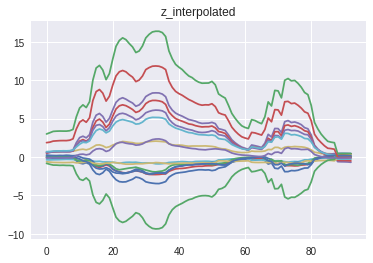

In [0]:
# TO-DO Change so this is interpolated between well-generalized voice and poorly generalized voice
# Concatenate along axis 1 because this axis contains sample lengths
z_mix = (np.concatenate((z, z_encoding_faster), axis=1) + z_encoding_slower) / 2.0
fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
plt.figure()
plt.plot(z_mix[0])
plt.title('z_interpolated')


In [0]:
# TO-DO - build all in function w/flags for which processing to apply to batches
# Start with reconstructions
z_list = [z_ for z_ in z]
name_list = ['z_stretches_interp' + name_ for name_ in names]

# Add all the mean interpolations
n = len(names)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (z[i] + z[j]) / 2.0
    new_name = 'interp_' + names[i] + '_X_'+ names[j]
    z_list.append(new_z)
    name_list.append(new_name)

save_paths = ['/content/' + name + '.wav' for name in name_list]    

fastgen.synthesize(z_mix, save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorflow:Sam

INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Sample: 10100
INFO:tensorflow:Sample: 10200
INFO:tensorflow:Sample: 10300
INFO:tensorflow:Sample: 10400
INFO:tensorflow:Sample: 10

INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INFO:tensorflow:Sample: 15500
INFO:tensorflow:Sample: 15600
INFO:tensorflow:Sample: 15700
INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:Sample: 17400
INFO:tensorflow:Sample: 17500
INFO:tensorflow:Sample: 17600
INFO:tensorflow:Sample: 17700
INFO:tensorflow:Sample: 17800
INFO:tensorflow:Sample: 17900
INFO:tensorflow:Sample: 18000
INFO:tensorflow:Sample: 18100
INFO:tensorflow:Sample: 18200


INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tensorflow:Sample: 23300
INFO:tensorflow:Sample: 23400
INFO:tensorflow:Sample: 23500
INFO:tensorflow:Sample: 23600
INFO:tensorflow:Sample: 23700
INFO:tensorflow:Sample: 23800
INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:Sample: 24700
INFO:tensorflow:Sample: 24800
INFO:tensorflow:Sample: 24900
INFO:tensorflow:Sample: 25000
INFO:tensorflow:Sample: 25100
INFO:tensorflow:Sample: 25200
INFO:tensorflow:Sample: 25300
INFO:tensorflow:Sample: 25400
INFO:tensorflow:Sample: 25500
INFO:tensorflow:Sample: 25600
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 25700
INFO:tensorflow:Sample: 25800


INFO:tensorflow:Sample: 30600
INFO:tensorflow:Sample: 30700
INFO:tensorflow:Sample: 30800
INFO:tensorflow:Sample: 30900
INFO:tensorflow:Sample: 31000
INFO:tensorflow:Sample: 31100
INFO:tensorflow:Sample: 31200
INFO:tensorflow:Sample: 31300
INFO:tensorflow:Sample: 31400
INFO:tensorflow:Sample: 31500
INFO:tensorflow:Sample: 31600
INFO:tensorflow:Sample: 31700
INFO:tensorflow:Sample: 31800
INFO:tensorflow:Sample: 31900
INFO:tensorflow:Sample: 32000
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 32100
INFO:tensorflow:Sample: 32200
INFO:tensorflow:Sample: 32300
INFO:tensorflow:Sample: 32400
INFO:tensorflow:Sample: 32500
INFO:tensorflow:Sample: 32600
INFO:tensorflow:Sample: 32700
INFO:tensorflow:Sample: 32800
INFO:tensorflow:Sample: 32900
INFO:tensorflow:Sample: 33000
INFO:tensorflow:Sample: 33100
INFO:tensorflow:Sample: 33200
INFO:tensorflow:Sample: 33300
INFO:tensorflow:Sample: 33400
INFO:tensorflow:Sample: 33500
INFO:tensorflow:Sample: 33600


INFO:tensorflow:Sample: 38300
INFO:tensorflow:Sample: 38400
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav
INFO:tensorflow:Sample: 38500
INFO:tensorflow:Sample: 38600
INFO:tensorflow:Sample: 38700
INFO:tensorflow:Sample: 38800
INFO:tensorflow:Sample: 38900
INFO:tensorflow:Sample: 39000
INFO:tensorflow:Sample: 39100
INFO:tensorflow:Sample: 39200
INFO:tensorflow:Sample: 39300
INFO:tensorflow:Sample: 39400
INFO:tensorflow:Sample: 39500
INFO:tensorflow:Sample: 39600
INFO:tensorflow:Sample: 39700
INFO:tensorflow:Sample: 39800
INFO:tensorflow:Sample: 39900
INFO:tensorflow:Sample: 40000
INFO:tensorflow:Sample: 40100
INFO:tensorflow:Sample: 40200
INFO:tensorflow:Sample: 40300
INFO:tensorflow:Sample: 40400
INFO:tensorflow:Sample: 40500
INFO:tensorflow:Sample: 40600
INFO:tensorflow:Sample: 40700
INFO:tensorflow:Sample: 40800
INFO:tensorflow:Sample: 40900
INFO:tensorflow:Sample: 41000
INFO:tensorflow:Sample: 41100
INFO:tensorflow:Sample: 41200
INFO:tensorflow:Sample: 41300


INFO:tensorflow:Sample: 45800
INFO:tensorflow:Sample: 45900
INFO:tensorflow:Sample: 46000
INFO:tensorflow:Sample: 46100
INFO:tensorflow:Sample: 46200
INFO:tensorflow:Sample: 46300
INFO:tensorflow:Sample: 46400
INFO:tensorflow:Sample: 46500
INFO:tensorflow:Sample: 46600
INFO:tensorflow:Sample: 46700
INFO:tensorflow:Sample: 46800
INFO:tensorflow:Sample: 46900
INFO:tensorflow:Sample: 47000
INFO:tensorflow:Sample: 47100
INFO:tensorflow:Sample: 47200
INFO:tensorflow:Sample: 47300
INFO:tensorflow:Sample: 47400
INFO:tensorflow:Sample: 47500
INFO:tensorflow:Sample: 47600
INFO:tensorflow:Saving: /content/z_stretches_interpTASCAM_0030S12.wav


In [0]:
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: z_stretches_interpTASCAM_0030S12.wav


In [0]:
print("Originals:\n")
for fname in file_list:
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Originals:

TASCAM_0030S12


Reconstructions:

z_stretches_interpTASCAM_0030S12


In [0]:
help(fastgen)

Help on module magenta.models.nsynth.wavenet.fastgen in magenta.models.nsynth.wavenet:

NAME
    magenta.models.nsynth.wavenet.fastgen - Utilities for "fast" wavenet generation with queues.

FILE
    /usr/local/lib/python2.7/dist-packages/magenta/models/nsynth/wavenet/fastgen.py

DESCRIPTION
    For more information, see:
    
    Ramachandran, P., Le Paine, T., Khorrami, P., Babaeizadeh, M.,
    Chang, S., Zhang, Y., ... Huang, T. (2017).
    Fast Generation For Convolutional Autoregressive Models, 1-5.

FUNCTIONS
    encode(wav_data, checkpoint_path, sample_length=64000)
        Generate an array of embeddings from an array of audio.
        
        Args:
          wav_data: Numpy array [batch_size, sample_length]
          checkpoint_path: Location of the pretrained model.
          sample_length: The total length of the final wave file, padded with 0s.
        Returns:
          encoding: a [mb, 125, 16] encoding (for 64000 sample audio file).
    
    load_batch(files, sample_len

In [0]:
# TO-DO: see wavenet utils.py for possibly linearly mapping samples to closest embeddings

fastgen.sample_categorical(utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR))

array([[7220.]])

Text(0.5,1,u'spectragram')

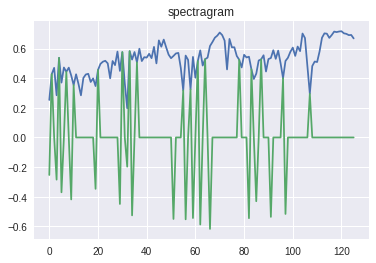

In [0]:
spectgram = utils.specgram(utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR))

plt.figure()
plt.plot(spectgram[0])
plt.title('spectragram')